In [1]:
import torch
import numpy as np
import Dataset
import importlib
import matplotlib.pyplot as plt
import networkx as nx

importlib.reload(Dataset)
EventContainer   = Dataset.EventContainer
DatasetContainer = Dataset.DatasetContainer
GraphDatasetContainer = Dataset.GraphDatasetContainer

def PLTParams(figsize = [20,20]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



In [2]:
DataPath = '/remote/tychodata/ftairli/work/Projects/Geometry_Reconstruction/Data/RawData'

In [3]:
# Importing Dataset
dataset = DatasetContainer(100)
dataset.Load(DataPath,'Test')

In [4]:
# Importing GraphDataset
GraphDataset = GraphDatasetContainer(0)
GraphDataset.Load(DataPath,'Test')

In [5]:
# Try to Produce The ProcessingDataset
def GetTruths(GraphDataset):
    ALLSDPPhi = GraphDataset._otherData[:,18]
    ALLSDPTheta = GraphDataset._otherData[:,19]
    
    # Truths = torch.cat((torch.cos(ALLSDPPhi).unsqueeze(1),torch.sin(ALLSDPPhi).unsqueeze(1),torch.cos(ALLSDPTheta).unsqueeze(1),torch.sin(ALLSDPTheta).unsqueeze(1)),dim=1)
    Truths = torch.cat((ALLSDPPhi.unsqueeze(1),ALLSDPTheta.unsqueeze(1)),dim=1)
    return Truths
def GetFeatures(GraphDataset):
    # Get Phi,Theta,Charge
    Features = GraphDataset._pixelData[:,[7,9,10,4]]
    # Normalise Features

    Features[:,1] = Features[:,1]
    Features[:,2] = Features[:,2]
    
    Features[:,3] = torch.log10(Features[:,3]+1)/7.25
    return Features




ProcessingDataset = GraphDataset.GetProcessingDataset(GetTruths,GetFeatures,True,True)
ProcessingDataset.AssignIndices()

In [6]:
ProcessingDataset._Features.shape

torch.Size([3362, 4])

In [7]:
ProcessingDataset.State = 'Train'
print(f'Training Lenght : {len(ProcessingDataset)}')
ProcessingDataset.State = 'Val'
print(f'Validation Lenght : {len(ProcessingDataset)}')
ProcessingDataset.State = 'Test'
print(f'Testing Lenght : {len(ProcessingDataset)}')


Training Lenght : 16
Validation Lenght : 2
Testing Lenght : 2


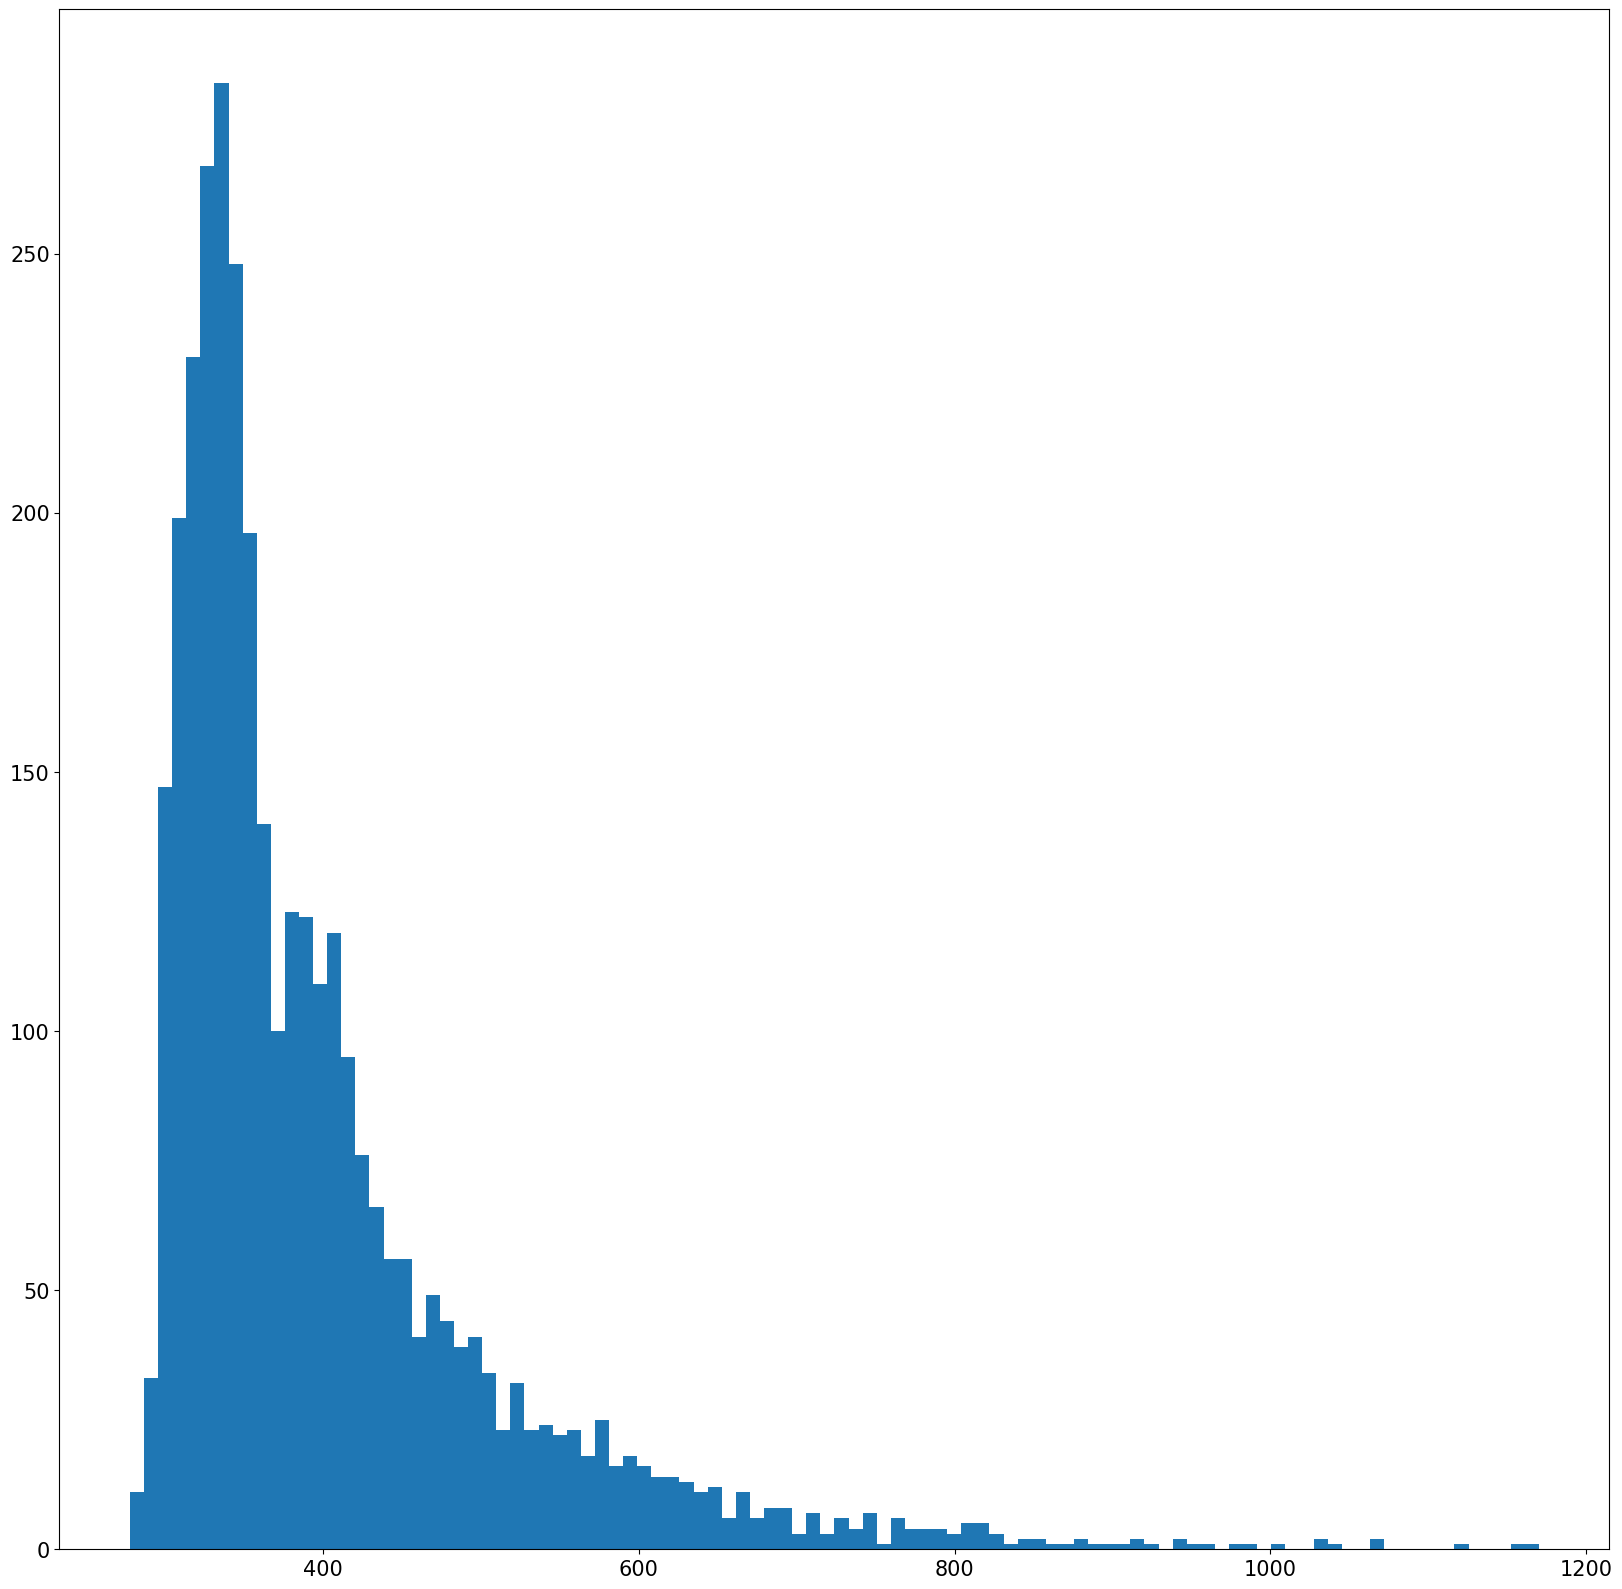

In [8]:
plt.hist(ProcessingDataset._Features[:,0].numpy(),bins=100)
plt.show()

In [9]:
from time import sleep

Random Event N: 0
BatchFeatures Shape : torch.Size([76, 3])
SDPTheta : 89.38634490966797
SDPPhi : 140.0005340576172


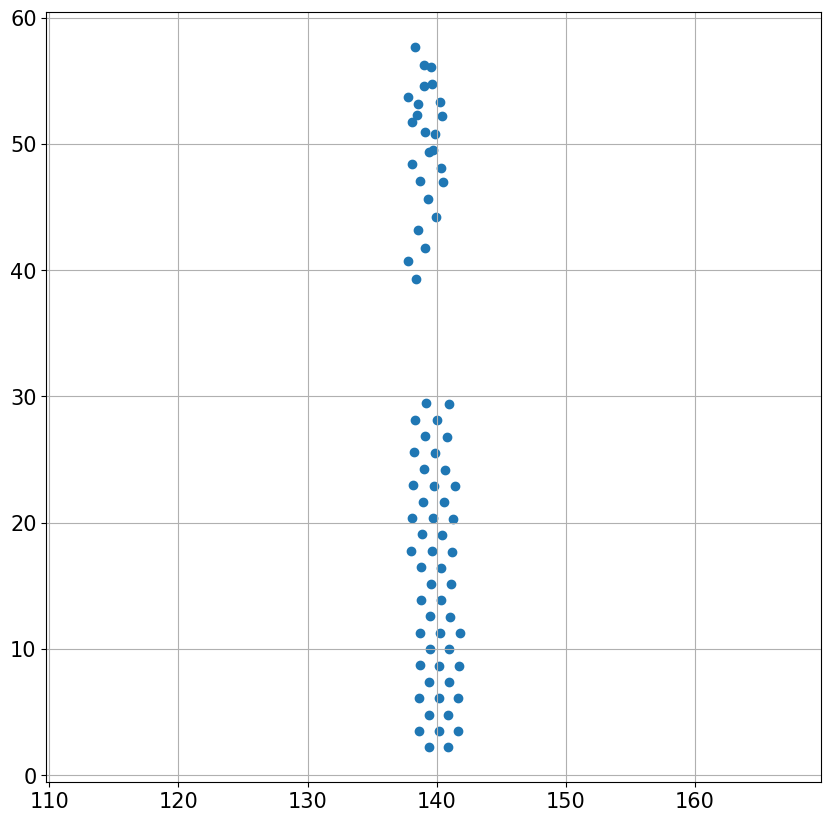

In [16]:
ProcessingDataset.State = 'Static'
N = torch.randint(0,len(ProcessingDataset),(1,1)).item()
N = 0
print(f'Random Event N: {N}')
All = False
if All: Kloop = range(20)
else: Kloop = range(N,N+1)
for N in Kloop:
    EvIndex, BatchFeatures,BatchEdges,BatchEdgeWeights,BatchTruthVals = ProcessingDataset[N]

    BatchFeatures = BatchFeatures[BatchFeatures[:,0].argsort()]
    BatchFeatures = BatchFeatures[:,1:]

    print(f'BatchFeatures Shape : {BatchFeatures.shape}')
    plt.figure(figsize=[10,10])
    plt.scatter(BatchFeatures[:,0],-BatchFeatures[:,1]+90)

    intercept = BatchTruthVals[0]/torch.pi*180-90
    slope = -torch.tan(BatchTruthVals[1])

    x = torch.linspace(torch.amin(BatchFeatures[:,0]).item(),torch.amax(BatchFeatures[:,0]).item(),100)
    y = slope * (x - intercept)
    # plt.plot(x, y, '-r', label='y = {}(x - {})'.format(slope, intercept))
    plt.gca().invert_xaxis()
    print(f'SDPTheta : {BatchTruthVals[1]/torch.pi*180}')
    if intercept>0:
        print(f'SDPPhi : {intercept}')
    else: 
        print(f'SDPPhi : {intercept+360}')
    x_center = (plt.xlim()[0] + plt.xlim()[1]) / 2  # Calculate the center of the x-axis
    threshold = 30
    if abs(x_center - plt.xlim()[0]) < threshold and abs(x_center - plt.xlim()[1]) < threshold:
        new_xlim = (x_center - threshold, x_center + threshold)
        plt.xlim(new_xlim)
    plt.grid()

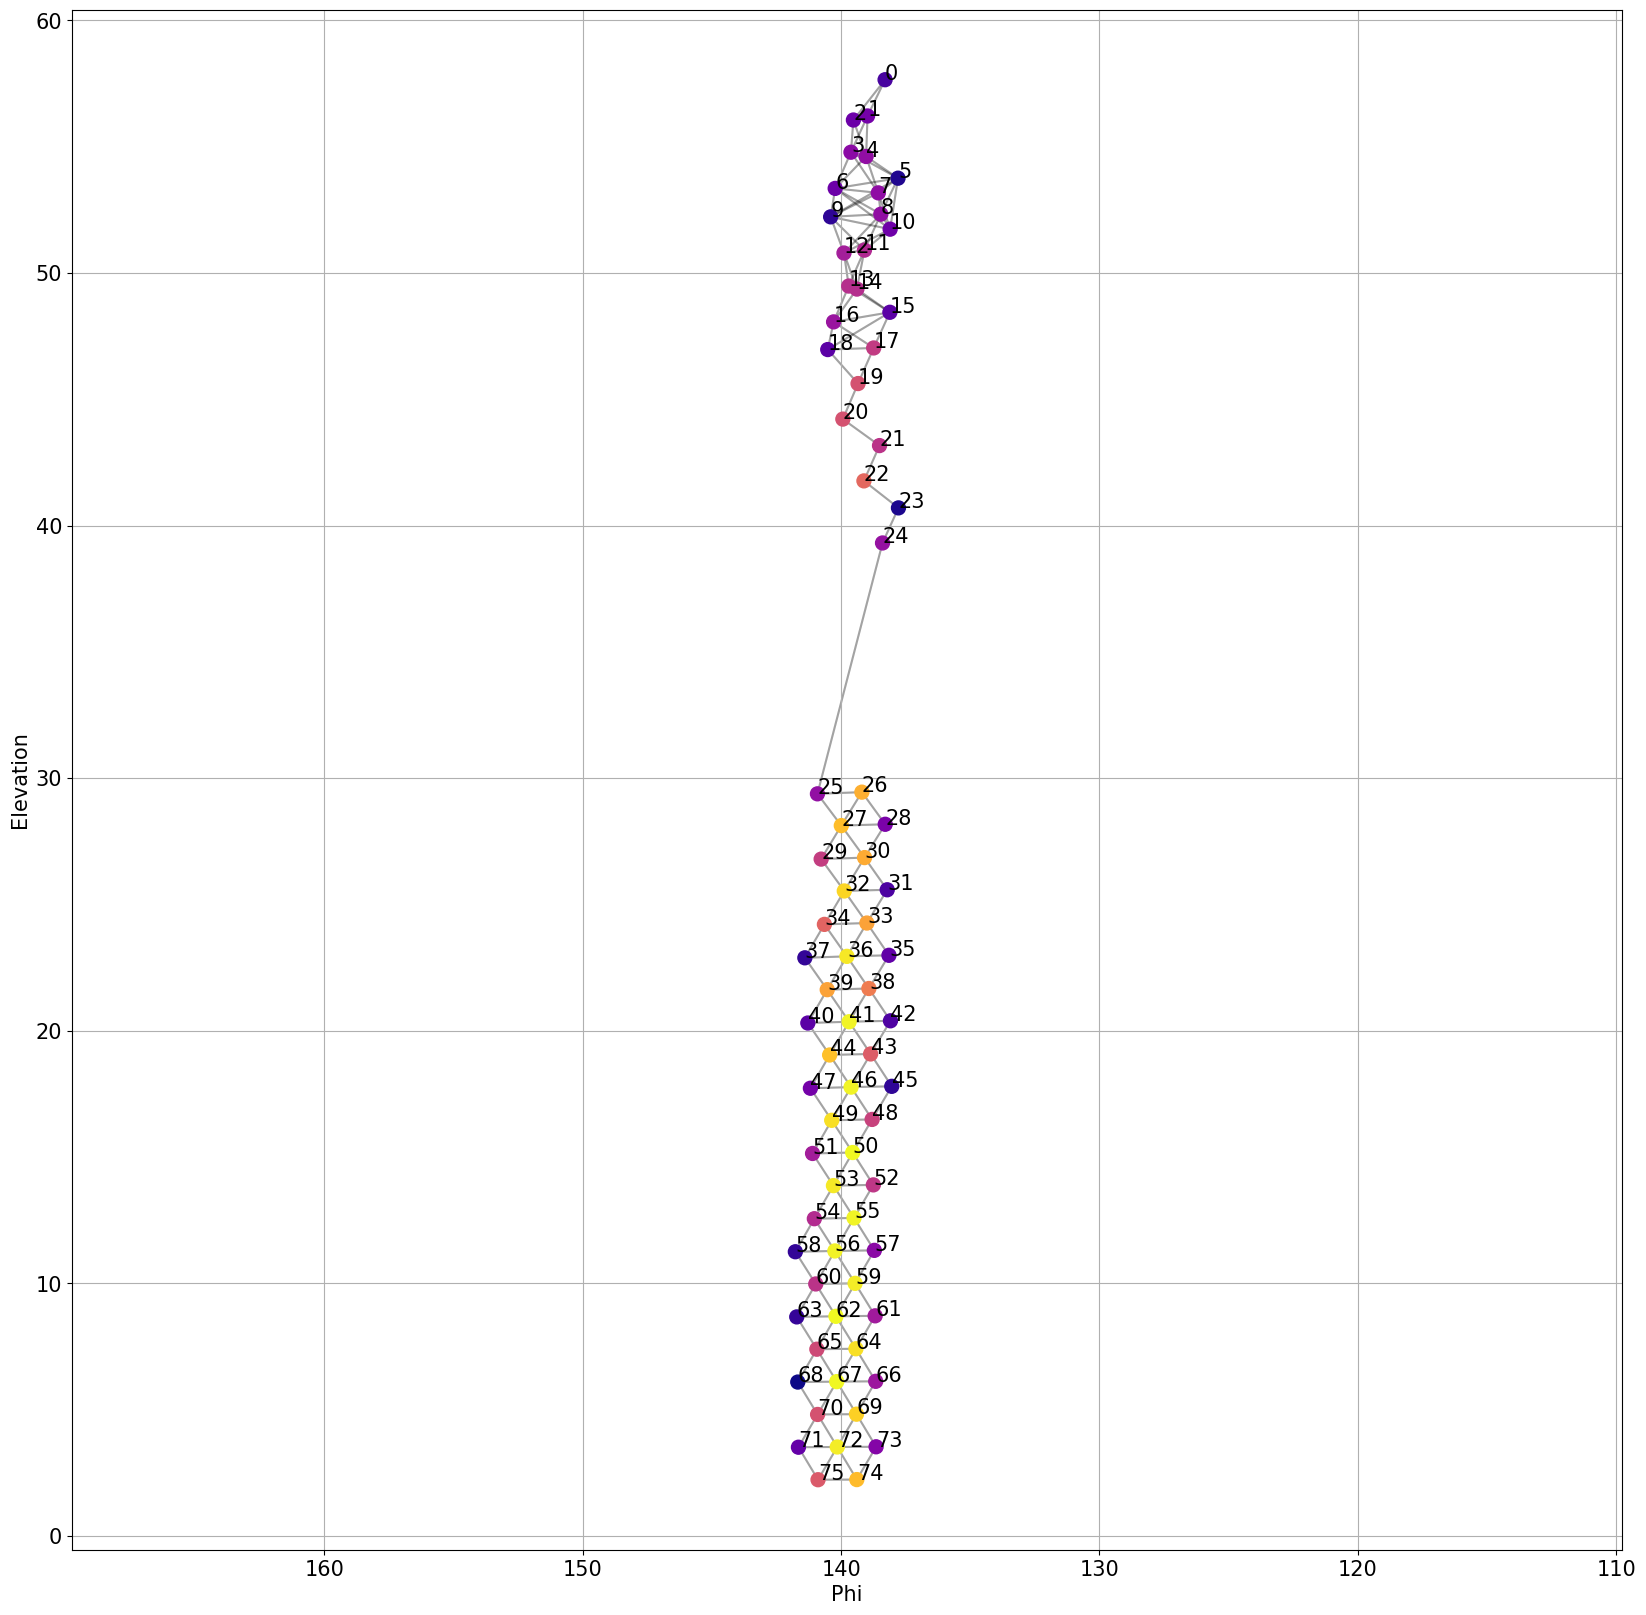

In [17]:
Adjacency = torch.zeros(torch.amax(BatchEdges.T)+1,torch.amax(BatchEdges.T)+1)
for i in range(len(BatchEdges.T)):
    Adjacency[BatchEdges.T[i,0],BatchEdges.T[i,1]] = 1
    Adjacency[BatchEdges.T[i,1],BatchEdges.T[i,0]] = 1

def PlotGraph(Pixels,Adjacency):
    plt.figure(figsize = [20,20])
    # Invert x axis
    for i in range(len(Adjacency)):
        for j in range(len(Adjacency)):
            if Adjacency[i,j] == 1:
                plt.plot([Pixels[i,0],Pixels[j,0]],[90-Pixels[i,1],90-Pixels[j,1]],c='black',alpha=0.2,zorder = 1)
    plt.scatter(Pixels[:,0][torch.sum(Adjacency,dim=1)!=0],90-Pixels[:,1][torch.sum(Adjacency,dim=1)!=0],c=Pixels[:,2][torch.sum(Adjacency,dim=1)!=0],cmap='plasma',s = 100,zorder = 2)
    plt.scatter(Pixels[:,0][torch.sum(Adjacency,dim=1)==0],90-Pixels[:,1][torch.sum(Adjacency,dim=1)==0],color='k',s = 50,marker='x',zorder = 2)
    for i in range(len(Pixels)):
        plt.annotate(str(i),(Pixels[i,0],90-Pixels[i,1]))
    plt.grid()
    plt.xlabel('Phi')
    plt.ylabel('Elevation')
    
    x_center = (plt.xlim()[0] + plt.xlim()[1]) / 2  # Calculate the center of the x-axis
    threshold = 30
    if abs(x_center - plt.xlim()[0]) < threshold and abs(x_center - plt.xlim()[1]) < threshold:
        new_xlim = (x_center - threshold, x_center + threshold)
        plt.xlim(new_xlim)
    plt.gca().invert_xaxis()
    plt.show()

PlotGraph(BatchFeatures,Adjacency)

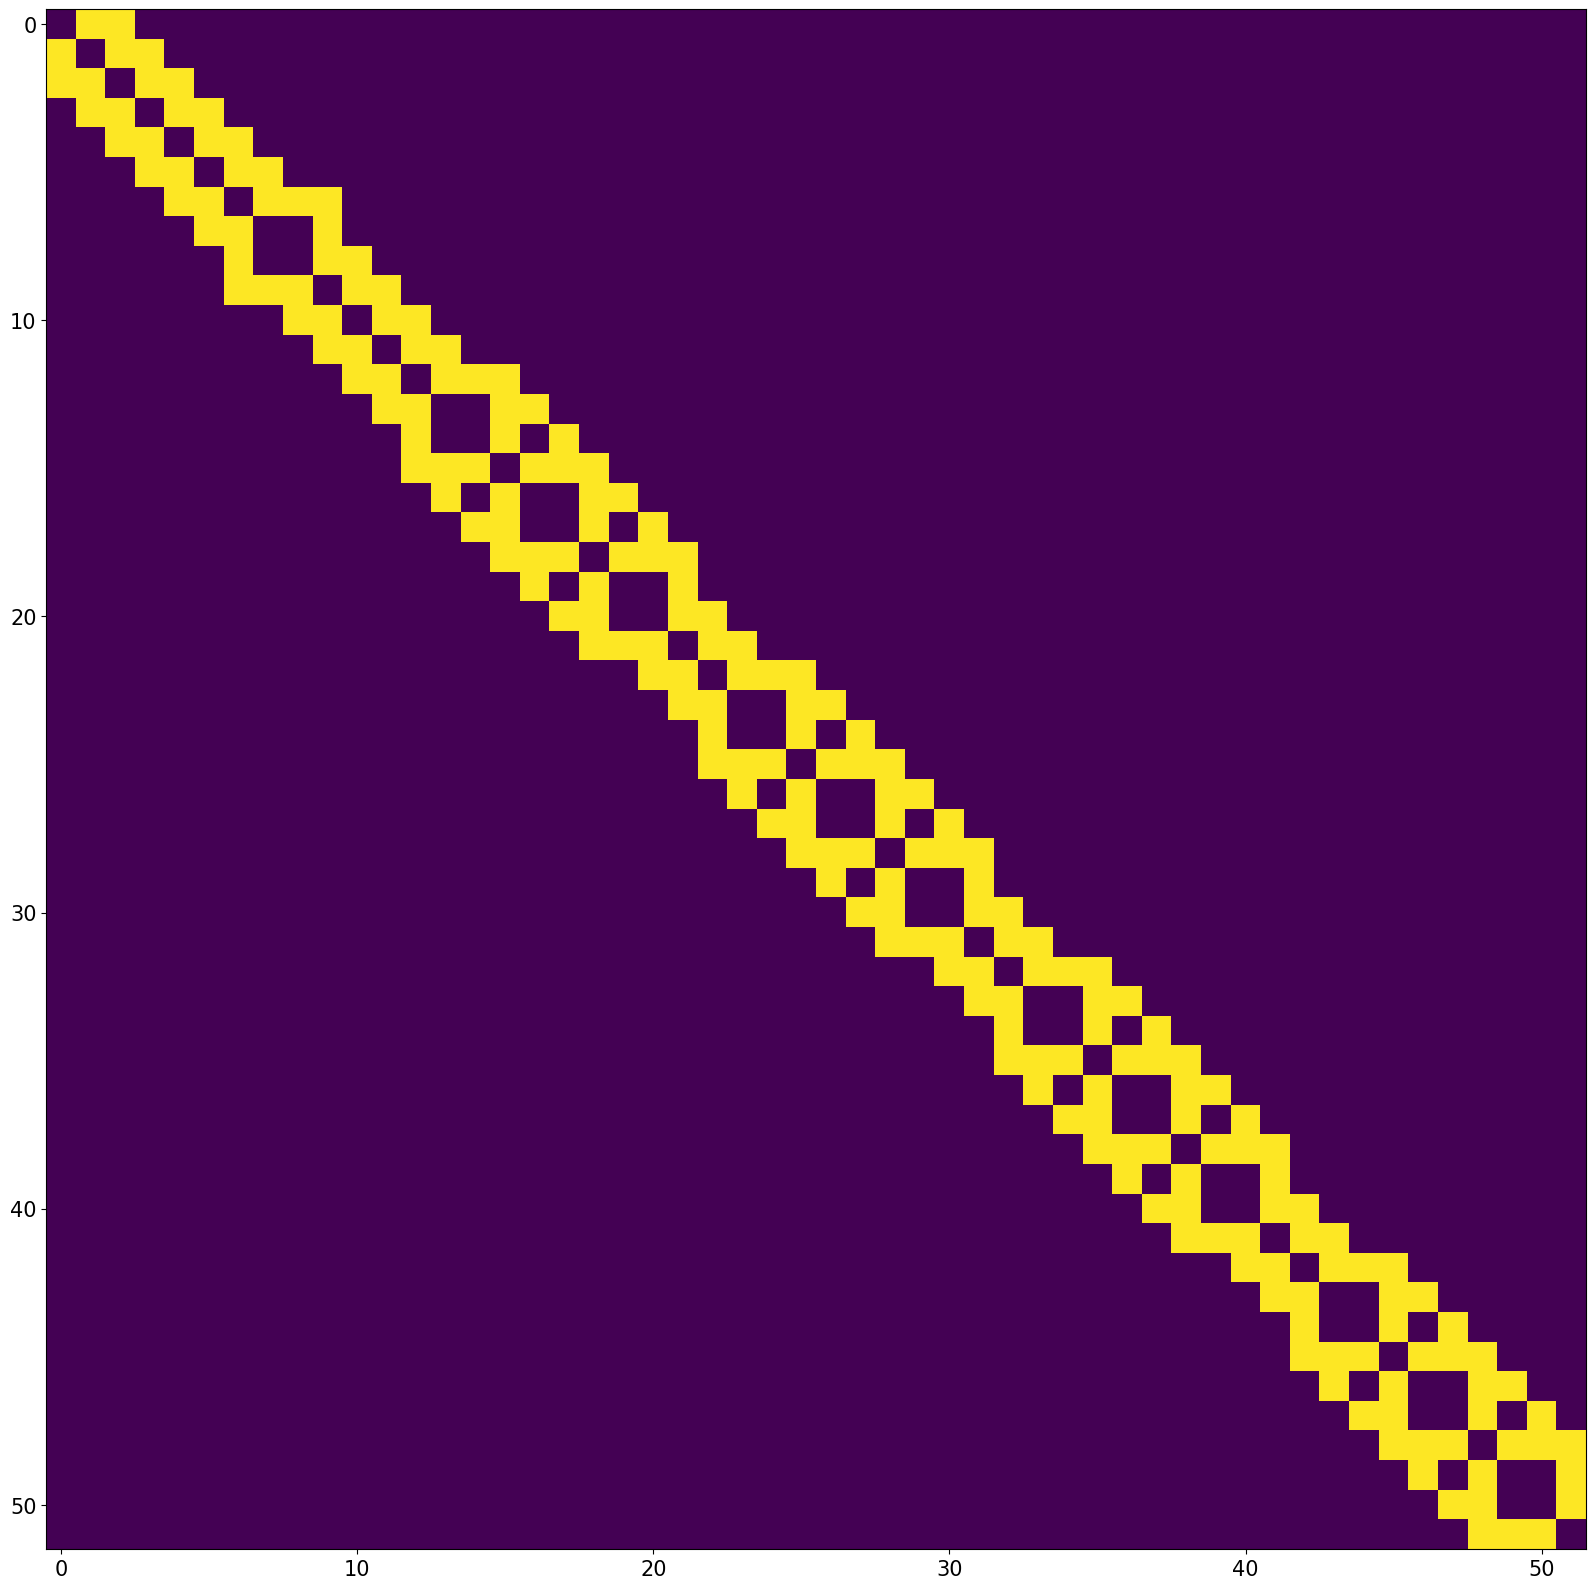

In [12]:
def PlotAdjacency(Adjacency):
    plt.figure(figsize = [20,20])
    plt.imshow(Adjacency)
    for i in range(len(Adjacency)):
        if torch.sum(Adjacency[i]) == 0:
            plt.axvline(i,color='red')
            plt.axhline(i,color='red')
    plt.show()

PlotAdjacency(Adjacency)

In [13]:
N = torch.randint(0,len(GraphDataset),(1,1)).item()

N = 0
Event,ActivePixels,Edges = GraphDataset.GetEventsByIndex(N)

Pixels = Event.PixelObservables


SDPTheta : 75.9344711303711
SDPPhi : -129.9764404296875


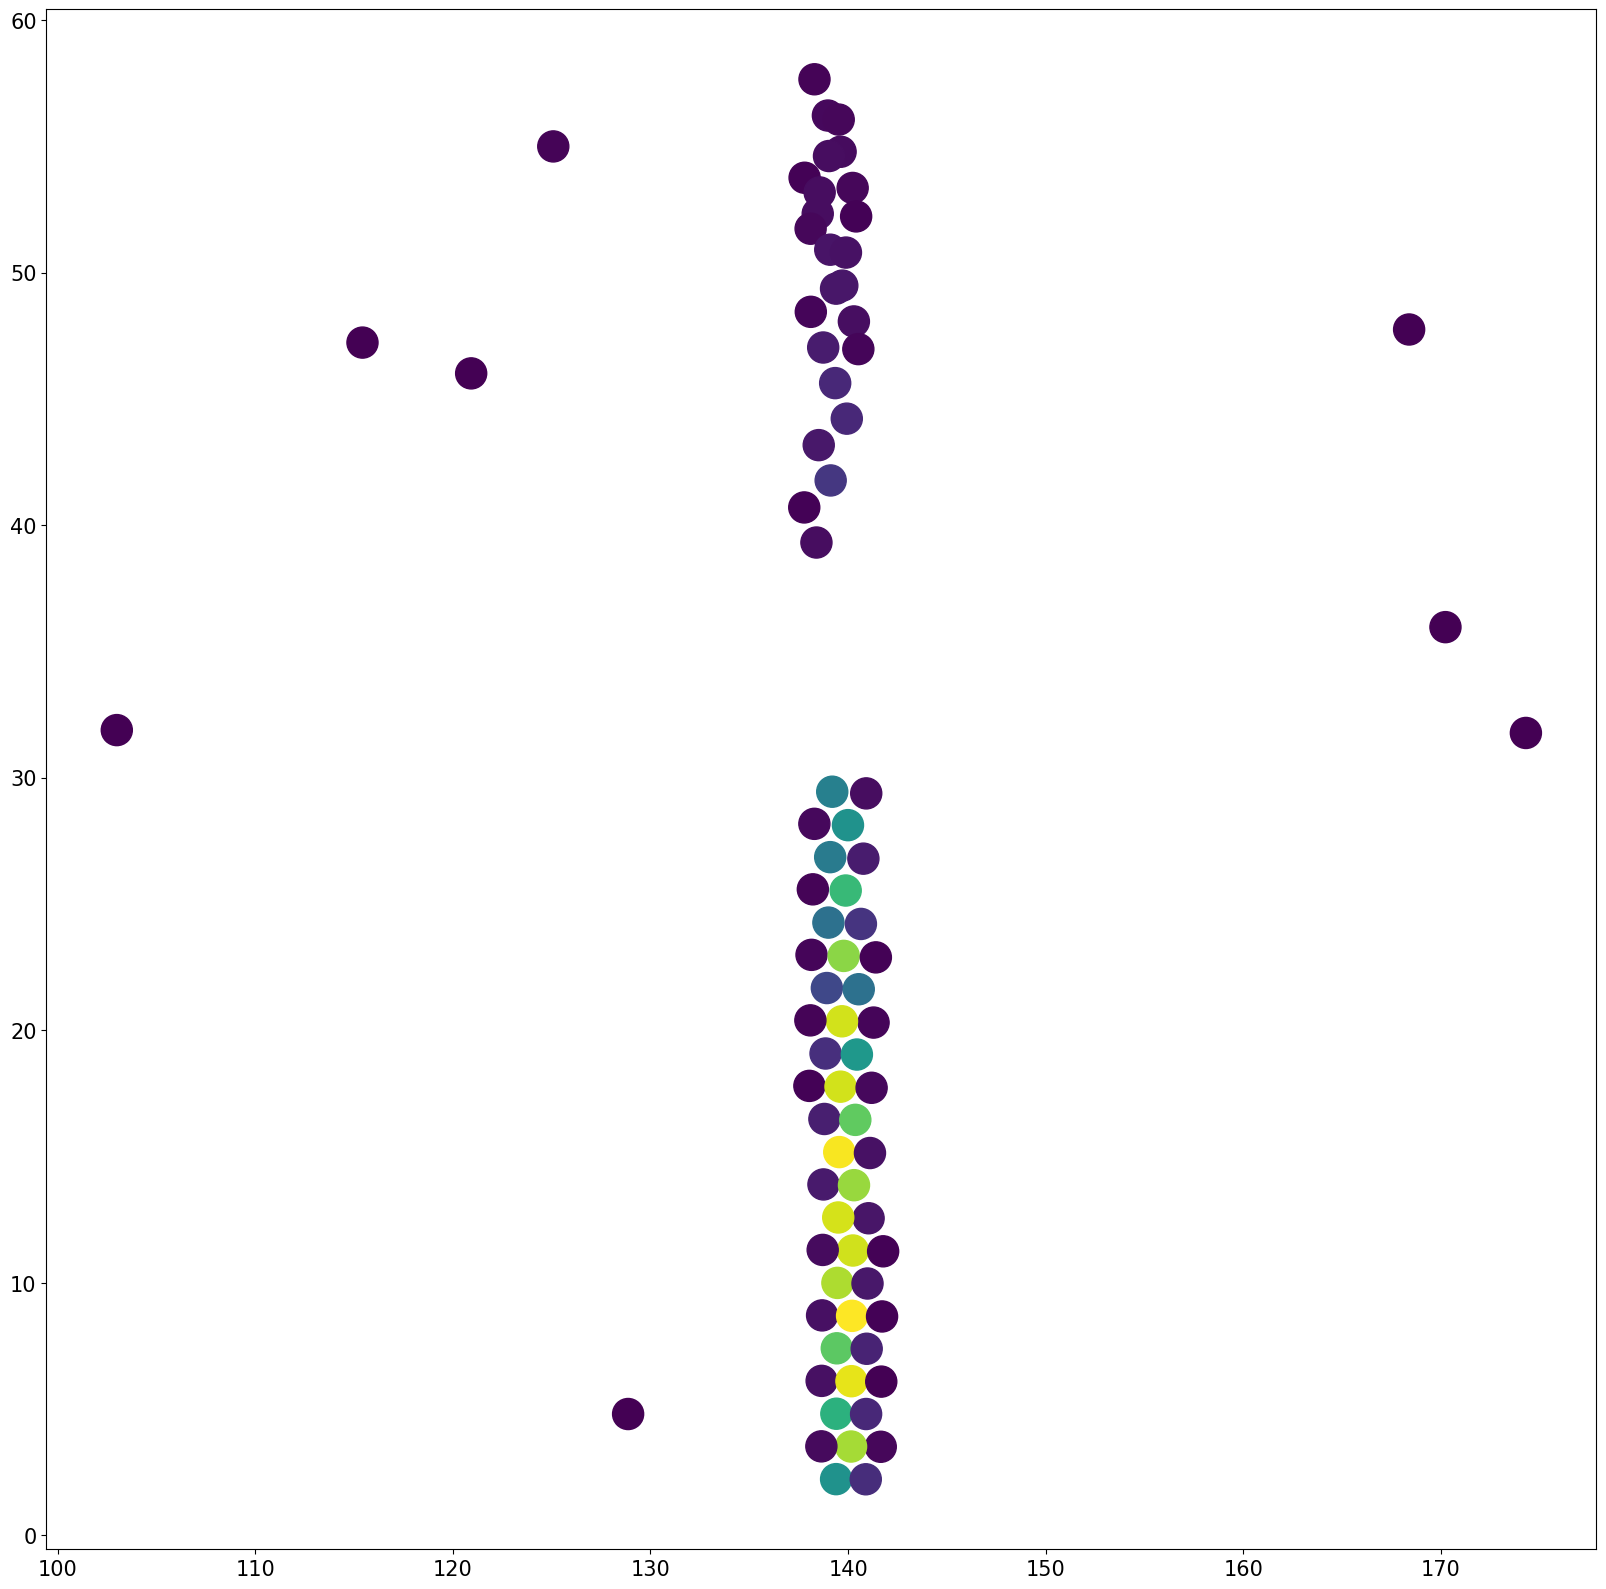

In [14]:
Phi = Event.RecSDPPhi
Theta = Event.RecSDPTheta

PixelsPhi = Pixels.PixelPhi
PixelsTheta = Pixels.PixelTheta

plt.scatter(PixelsPhi,-PixelsTheta+90,c = Pixels.Charge,s = 500)
intercept = Phi/torch.pi*180
Rise = -torch.cos(Theta)
Run  = torch.sin(Theta)
slope = Rise/Run

x = torch.linspace(torch.amin(BatchFeatures[:,0]).item(),torch.amax(BatchFeatures[:,0]).item(),100)
y = slope * (x - intercept)
# plt.plot(x, y, '-r', label='y = {}(x - {})'.format(slope, intercept))

print(f'SDPTheta : {BatchTruthVals[1]/torch.pi*180}')
print(f'SDPPhi : {intercept}')

In [15]:
for N in range(20):
    Event = dataset.GetEventsByIndex(N)
    print(f'Event GenSDPPhi : {Event.GenSDPPhi*180/torch.pi} Event RecSDPPhi : {Event.RecSDPPhi*180/torch.pi}')

Event GenSDPPhi : -129.9994659423828 Event RecSDPPhi : -129.97642517089844
Event GenSDPPhi : 108.84003448486328 Event RecSDPPhi : 108.75578308105469
Event GenSDPPhi : -179.9918670654297 Event RecSDPPhi : 179.98294067382812
Event GenSDPPhi : 131.38375854492188 Event RecSDPPhi : 131.3337860107422


Event GenSDPPhi : 134.01171875 Event RecSDPPhi : 133.82508850097656
Event GenSDPPhi : -114.70305633544922 Event RecSDPPhi : -114.71199035644531
Event GenSDPPhi : 166.82435607910156 Event RecSDPPhi : 166.7991943359375
Event GenSDPPhi : 120.86148834228516 Event RecSDPPhi : 120.87945556640625
Event GenSDPPhi : -158.15553283691406 Event RecSDPPhi : -157.90414428710938
Event GenSDPPhi : 179.22726440429688 Event RecSDPPhi : 179.52235412597656
Event GenSDPPhi : 169.91128540039062 Event RecSDPPhi : 169.8447265625
Event GenSDPPhi : 171.7220458984375 Event RecSDPPhi : 171.8810272216797
Event GenSDPPhi : -161.99452209472656 Event RecSDPPhi : -162.024658203125
Event GenSDPPhi : -137.56536865234375 Event RecSDPPhi : -137.5553436279297
Event GenSDPPhi : 164.40907287597656 Event RecSDPPhi : 164.41929626464844
Event GenSDPPhi : 88.27108764648438 Event RecSDPPhi : 88.2327651977539
Event GenSDPPhi : 145.53433227539062 Event RecSDPPhi : 145.26052856445312
Event GenSDPPhi : -160.11691284179688 Event RecSD

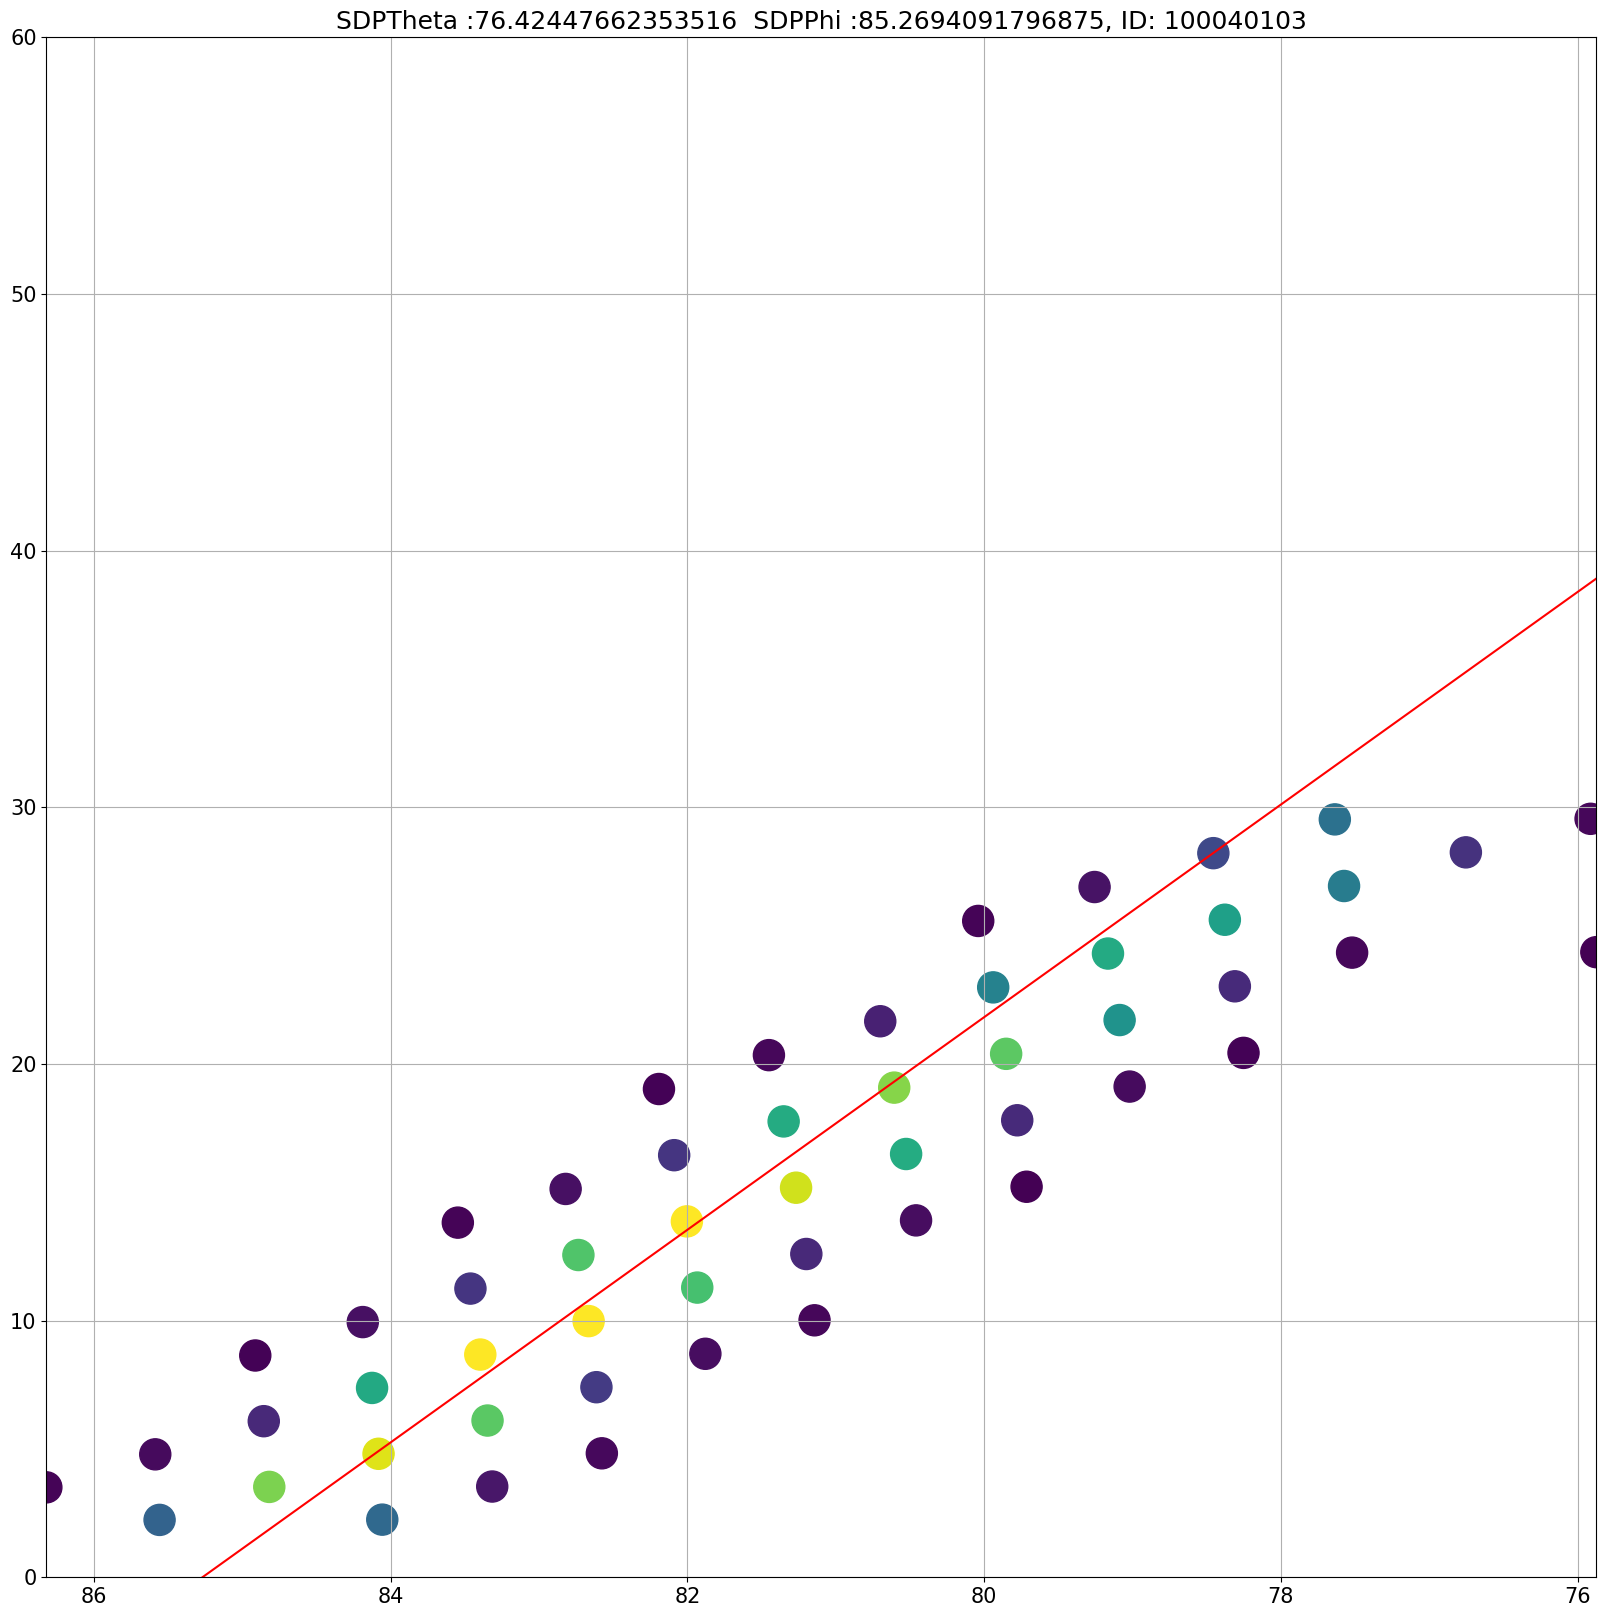

In [16]:
# N = torch.randint(0,len(dataset),(1,1)).item()

Event = dataset.GetEventsByIndex(N)

Pixels = Event.PixelObservables
Phi = Event.RecSDPPhi
Theta = Event.RecSDPTheta

PixelsPhi = Pixels.GetPixelData()[:,9]
PixelsTheta = Pixels.GetPixelData()[:,10]
plt.figure()
plt.scatter(PixelsPhi,-PixelsTheta+90,c = Pixels.Charge,s = 500)
intercept = (Phi-torch.pi/2)/torch.pi*180
slope = -torch.tan(Theta)

x = torch.linspace(torch.amin(PixelsPhi).item(),torch.amax(PixelsPhi).item(),100)
y = slope * (x - intercept)
# print(x,y)
plt.plot(x, y, '-r')

plt.grid()
plt.title(f'SDPTheta :{(Theta*180/torch.pi)}  SDPPhi :{(Phi*180/torch.pi-90)}, ID: {Event.EventID}')
plt.ylim([0,60])
plt.xlim([torch.amin(PixelsPhi).item(),torch.amax(PixelsPhi).item()])
plt.gca().invert_xaxis()
# print(f'SDPTheta : {Phi/torch.pi*180}')
# print(f'SDPPhi : {Theta/torch.pi*180}')
    

In [17]:
All_otherData = torch.load('/remote/tychodata/ftairli/work/Projects/GNN_SDP/Data/RawData/ALL_otherData.pt')

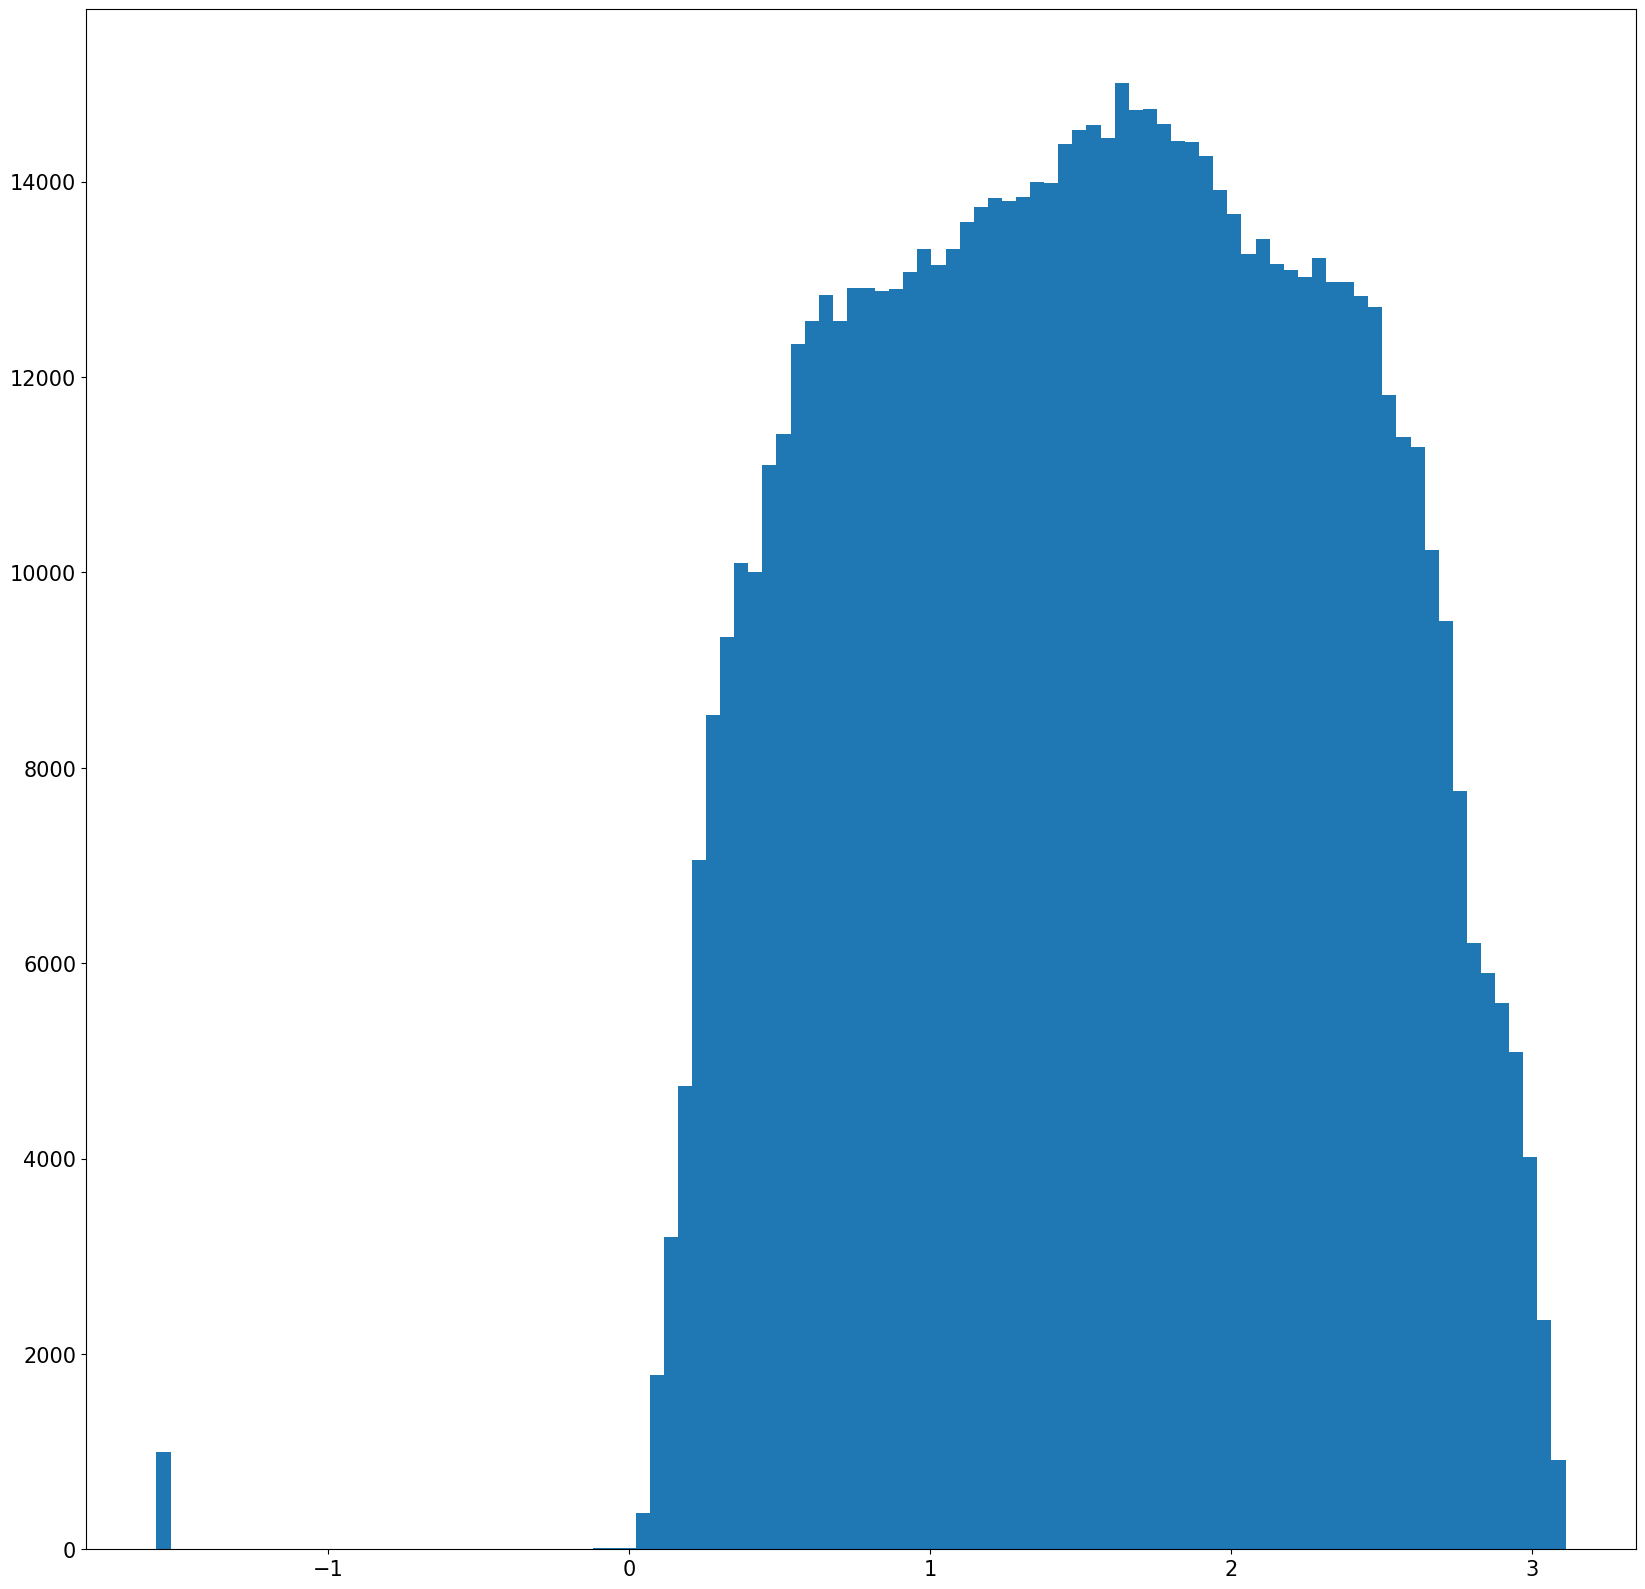

In [18]:
ALL_Phi = All_otherData[:,18].clone().numpy()
ALL_Theta = All_otherData[:,19].numpy()
X =  ALL_Phi
X[X<0] = (X[X<0])+torch.pi*2
X = X -torch.pi/2
plt.hist(X,bins=100)
plt.show()

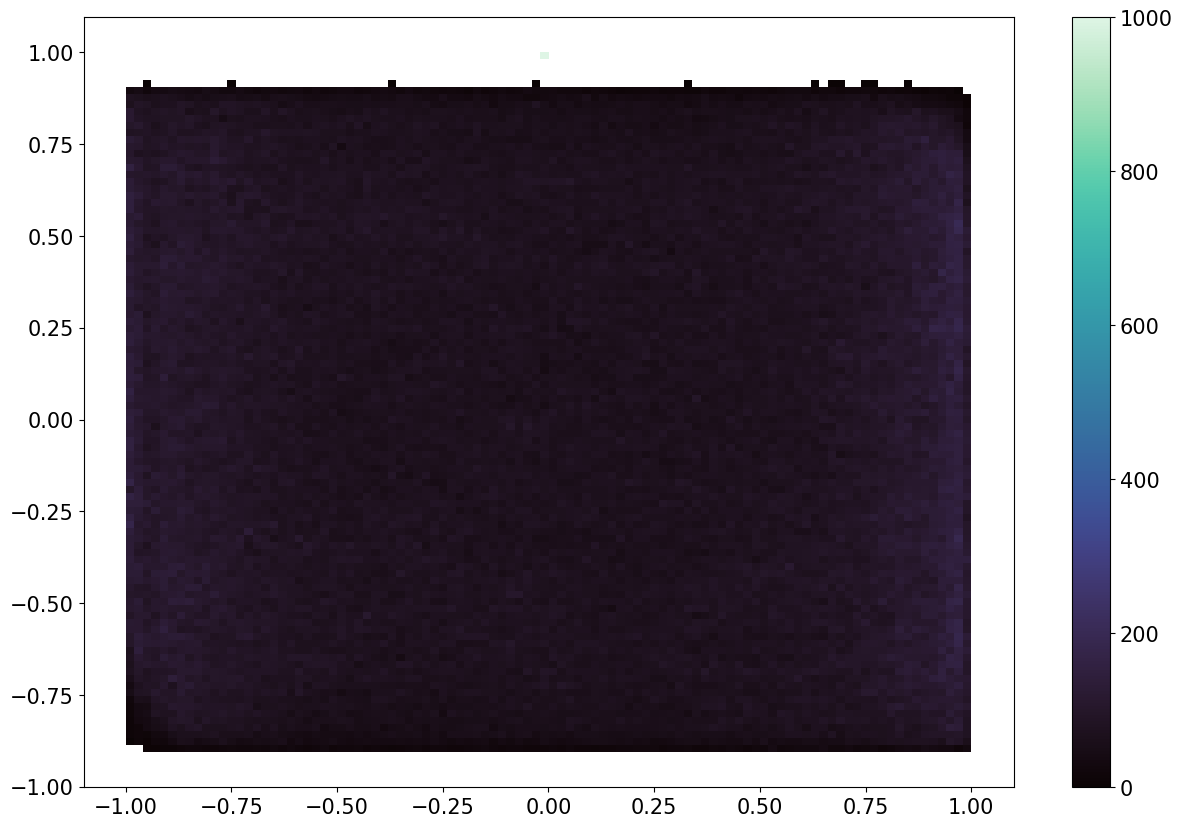

In [19]:
import seaborn as sns
X = np.sin(ALL_Phi)
Y = np.cos(ALL_Theta)

fig,ax =plt.subplots(1, 1, figsize=(15, 10))

# Scatter plot for the first subplot
# sns.scatterplot(x=X, y=Y, ax=ax, s=5,color='.15')
sns.histplot(x=X, y=Y, ax=ax, bins=100, pthresh=0,cmap = 'mako',cbar=True)
# ax[0].set_xlabel('Truth Phi (degrees)')
# ax[0].set_ylabel('Prediction-Truth (degrees)')
# ax[0].set_title('Phi')
# ax[0].set_xlim(-40,40)
# ax[0].set_ylim(-10,10)

plt.show()


In [20]:
np.cos(170/180*np.pi)

-0.984807753012208